# Linear Models with Stochastic Gradient Descent

## ... about machine learning (a reminder from lesson 1)

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies).  We looked at random forests in depth as we analyzed the Blue Book for Bulldozers dataset.

2. Multi-layered neural networks learnt with SGD (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this lesson, we will start on the 2nd approach (a neural network with SGD) by analyzing the MNIST dataset.  You may be surprised to learn that **logistic regression is actually an example of a simple neural net**!

## About The Data

In this lesson, we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

### Download

Let's download, unzip, and format the data.

In [2]:
path = '../data/'

In [3]:
import os
os.makedirs(path, exist_ok=True)

In [4]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [201]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [6]:
type(x)

numpy.ndarray

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [202]:
mean = x.mean()
std = x.std()

In [203]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [204]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [205]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [206]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

#### Plots 

In [207]:
x_valid.shape

(10000, 784)

In [208]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

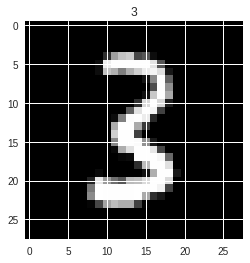

In [209]:
show(x_imgs[0], y_valid[0])

In [210]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [211]:
y_valid[0]

3

We can look at part of an image:

In [212]:
x_imgs[0,10:15,10:15]

array([[-0.4245, -0.4245, -0.4245, -0.4245,  0.1729],
       [-0.4245, -0.4245, -0.4245,  0.7831,  2.4357],
       [-0.4245, -0.272 ,  1.2026,  2.7789,  2.8043],
       [-0.4245,  1.7619,  2.8043,  2.8043,  1.7365],
       [-0.4245,  2.2069,  2.8043,  2.8043,  0.4018]], dtype=float32)

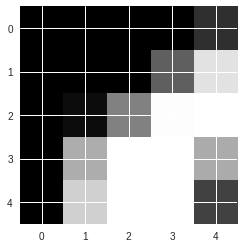

In [213]:
show(x_imgs[0,10:15,10:15])

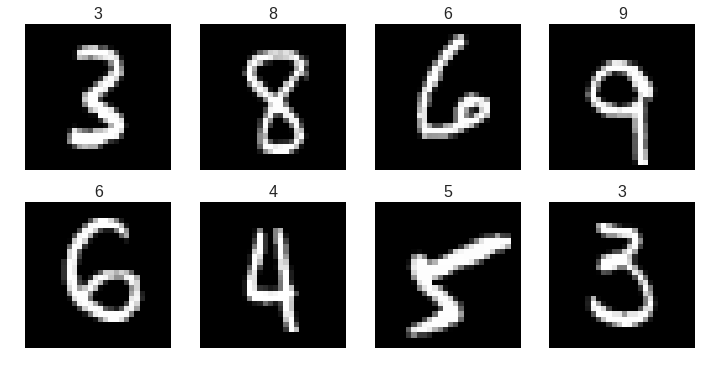

In [214]:
plots(x_imgs[:8], titles=y_valid[:8])

## Logistic regression

In [215]:
from sklearn import linear_model, metrics

Let's start by using the sklearn implementation:

In [216]:
regr = linear_model.LogisticRegression(C=50. / len(x),
                                     # multi_class='multinomial',
                                     # penalty='l2', 
                                     #  tol=0.1
                                      )
# %timeit regr.fit(x, y)

In [217]:
regr.fit(x,y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training set error:

In [218]:
pred = regr.predict(x)

In [219]:
(pred == y).sum()/len(pred)

0.90502000000000005

In [220]:
pred = regr.predict(x_valid)

Validation Set Error:

In [221]:
(pred == y_valid).sum()/len(pred)

0.91369999999999996

Not bad for our 1st attempt.  We are getting 91% accuracy with our logistic regression model.

It will be helpful to have some metrics on how good our prediciton is.  We will look at the mean squared norm (L2) and mean absolute error (L1).

In [222]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

In [223]:
regr_metrics(y_valid, regr.predict(x_valid))

(1.2376186811776881, 0.31690000000000002)

To take a deeper look at what logistic regression is doing and how we can program it ourselves, we are going to put it in context as a specific example of a shallow neural net.

## Neural Networks

**What is a neural network?**

A *neural network* is an *infinitely flexible function*, consisting of *layers*.  A *layer* is matrix multiplication (which is linear) followed by a non-linear function (the *activation*).

One of the tricky parts of neural networks is just keeping track of all the vocabulary!

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif fast.ai Practical Deep Learning for Coders course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

## PyTorch

We will be using the open source [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.  This is the highest level, simplest way to get started with deep learning. Please note that fastai requires Python 3 to function. It is currently in pre-alpha, so items may move around and more documentation will be added in the future.

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

### About GPUs

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.  The only change needed to the code is to remove `.cuda()` wherever it appears.
- **Use crestle, through your browser**: [Crestle](https://www.crestle.com/) is a service that gives you an already set up cloud service with all the popular scientific and deep learning frameworks already pre-installed and configured to run on a GPU in the cloud. It is easily accessed through your browser. New users get 10 hours and 1 GB of storage for free. After this, GPU usage is 34 cents per hour. I recommend this option to those who are new to AWS or new to using the console.
- **Set up an AWS instance through your console**: You can create an AWS instance with a GPU by following the steps in this  [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]  AWS charges 90 cents per hour for this.

## Neural Net for Logistic Regression in PyTorch

In [71]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [224]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
).cuda()

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.  In our case, we are not interested in viewing the probabilites, and just want to see what the most likely guess is.

In [225]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [226]:
x.shape

(50000, 784)

In [227]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [228]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)



  0%|          | 0/782 [00:00<?, ?it/s]
                                       
                                       
                                       
                                       

  0%|          | 1/782 [00:00<04:17,  3.03it/s, loss=2.61]

  7%|▋         | 57/782 [00:00<02:47,  4.32it/s, loss=0.903]

 14%|█▍        | 110/782 [00:00<01:49,  6.15it/s, loss=0.597]

 20%|██        | 160/782 [00:00<01:11,  8.73it/s, loss=0.484]

 27%|██▋       | 209/782 [00:00<00:46, 12.38it/s, loss=0.433]

 33%|███▎      | 256/782 [00:00<00:30, 17.49it/s, loss=0.426]

 39%|███▉      | 306/782 [00:00<00:19, 24.61it/s, loss=0.387]

 46%|████▌     | 361/782 [00:01<00:12, 34.49it/s, loss=0.366]

 53%|█████▎    | 418/782 [00:01<00:07, 48.01it/s, loss=0.358]

 60%|██████    | 473/782 [00:01<00:04, 66.09it/s, loss=0.338]

 69%|██████▉   | 540/782 [00:01<00:02, 90.51it/s, loss=0.348]

 77%|███████▋  | 602/782 [00:01<00:01, 121.62it/s, loss=0.335]

 85%|████████▌ | 666/782 [00:01<00:00, 160.5

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [229]:
preds = predict(net, md.val_dl)

In [230]:
preds.argmax(1)[:5]

array([3, 8, 6, 9, 6])

In [231]:
preds.shape

(10000, 10)

In [232]:
preds = preds.argmax(1)

**Validation Set accuracy:**

In [233]:
np.sum(preds == y_valid)/len(preds)

0.91220000000000001

Let's see how some of our preditions look!

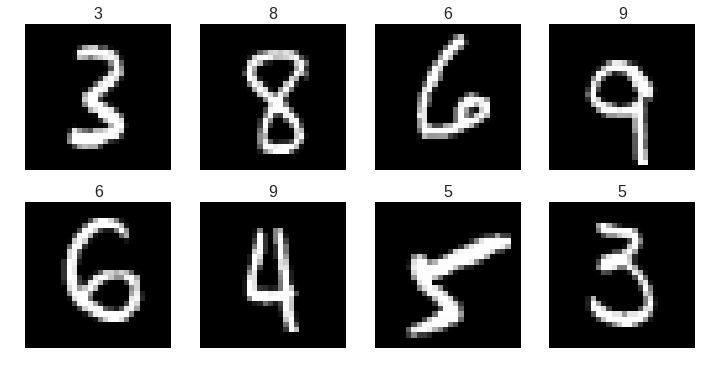

In [234]:
plots(x_imgs[:8], titles=preds[:8])

Validation Set accuracy:

In [235]:
np.sum(preds == y_valid)

9122

In [236]:
preds[:8]

array([3, 8, 6, 9, 6, 9, 5, 5])

## Defining Logistic Regression Ourselves

`Linear` is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.  

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

PyTorch class has two things: constructor (says parameters) and a forward method (how to calculate prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [237]:
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

In [238]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(torch.exp(x)/(1 + torch.exp(x).sum(dim=0)))        # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [239]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [240]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)


                                       

                                       


                                       
                                       
                                       
                                       
                                       

  0%|          | 1/782 [00:00<02:35,  5.02it/s, loss=4.17]

  5%|▌         | 43/782 [00:00<01:43,  7.14it/s, loss=2.98]

 11%|█         | 87/782 [00:00<01:08, 10.13it/s, loss=2.73]

 17%|█▋        | 132/782 [00:00<00:45, 14.33it/s, loss=2.64]

 23%|██▎       | 177/782 [00:00<00:29, 20.19it/s, loss=2.6] 

 28%|██▊       | 222/782 [00:00<00:19, 28.30it/s, loss=2.56]

 34%|███▍      | 269/782 [00:00<00:13, 39.39it/s, loss=2.53]

 40%|████      | 316/782 [00:00<00:08, 54.30it/s, loss=2.52]

 47%|████▋     | 370/782 [00:01<00:05, 74.36it/s, loss=2.51]

 55%|█████▍    | 427/782 [00:01<00:03, 100.56it/s, loss=2.49]

 62%|██████▏   | 484/782 [00:01<00:02, 133.54it/s, loss=2.49]

 69%|██████▉   | 541/782 [00:01<00:

Now we can check our predictions:

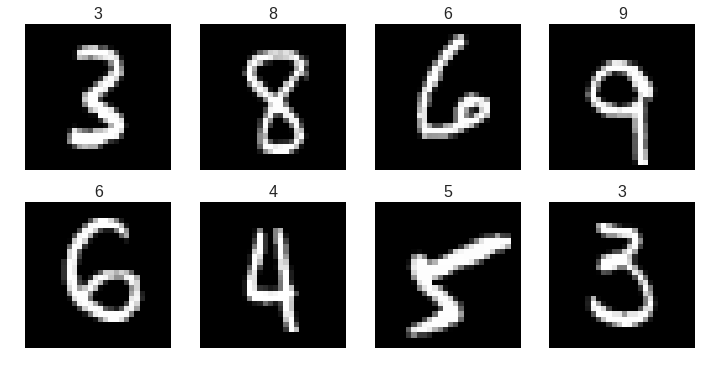

In [241]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [242]:
np.sum(preds == y_valid)/len(preds)

0.91139999999999999

## Writing Our Own Training Loop

In [271]:
net2 = LogReg().cuda()
loss_fn=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        # Forward pass: compute predicted y by passing x to the model.
        x, y = next(dl)
        y_pred = net2.forward(Variable(x).cuda())

        # Compute and print loss.
        loss = loss_fn(y_pred, Variable(y).cuda())
        losses.append(loss)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()
        # print(loss.data)

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))


                                       

                                       
                                       
                                       
                                       
                                       
                                       0.910429936306


In [268]:
def score(x, y):
    y_pred = to_np(net2.forward(Variable(x.cuda())))
    # print(y_pred.shape, y.shape)
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [269]:
x_,y_=next(iter(md.val_dl))
score(x_,y_)

0.9375

In [256]:
y_pred.shape

(64, 10)

In [264]:
y_pred.argmax(axis=1)[:10]== to_np(y_[:10])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [260]:
y_pred.argmax(axis=1) == y_

/home/racheltho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


TypeError: eq received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)
 * (torch.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)


In [267]:
np.sum(y_pred.argmax(axis=1) == to_np(y_))/len(y_pred)

0.9375

## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

## More about Layers

Sequential defines layers of our network, so let's talk about layers. Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.  Deeper layers are able to capture more complex patterns.

Layer 1 of a convolutional neural network:
<img src="images/zeiler1.png" alt="pytorch" style="width: 40%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Layer 2:
<img src="images/zeiler2.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Deeper layers can learn about more complicated shapes (although we are only using 2 layers in our network):
<img src="images/zeiler4.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>